# "Needle Sac"

My normal SAC, but with an extra replay buffer. 

In [ ]:
# Do rollouts, and add to our experience buffers
ep_obs1, ep_obs2, ep_acts, ep_rews, ep_done = do_rollout(env, model, env_steps)
in_goal = torch.sum(torch.sqrt((ep_obs2[-goal_lookback:] - goal_state) ** 2), axis=1) < goal_thresh

# Only add to the needle buffer if we consider it to have reached the goal state
if in_goal.all():
    needle_buf.store(ep_obs1, ep_obs2, ep_acts, ep_rews, ep_done)

# Always add to our primary replay buffer
replay_buf.store(ep_obs1, ep_obs2, ep_acts, ep_rews, ep_done)

## ===========================================================

# When it's time to train, sample from one of the two buffers with some probabiltiy
p = np.random.random_sample(1)
if p > needle_lookup_prob and needle_buf.size > 0:
    replay_obs1, replay_obs2, replay_acts, replay_rews, replay_done = needle_buf.sample_batch(replay_batch_size)
else:
    replay_obs1, replay_obs2, replay_acts, replay_rews, replay_done = replay_buf.sample_batch(replay_batch_size)

# do updates using replay_*

In [1]:
# TODO: shrink


import gym
import seagul.envs
import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
dtype = np.float32

import pandas as pd
import matplotlib.pyplot as plt

import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import random
import tensorflow as tf
import itertools
%matplotlib inline

from torch.multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os

/home/sgillen/work/seagul/seagul/envs/__init__.py:47: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


In [2]:
jup_dir = "/home/sgillen/work/"

def load_trials(trial_dir):
    directory = jup_dir + trial_dir

    ws_list = []
    model_list = []
    min_length = float('inf')
    for entry in os.scandir(directory):
                model, env, args, ws = load_workspace(entry.path)
                
                if len(ws["raw_rew_hist"]) < min_length:
                    min_length = len(ws["raw_rew_hist"])
                    
                ws_list.append(ws)
                model_list.append(model)

    min_length = int(min_length)
    rewards = np.zeros((min_length, len(ws_list)))
    for i,ws in enumerate(ws_list):
        rewards[:,i] = np.array(ws["raw_rew_hist"][:min_length])



    return ws_list, model_list, rewards

def do_rollout(init_point):
    env = gym.make(ws['env_name'], **ws['env_config'])
    if init_point is not None:
        obs = env.reset(init_point)
    else:
        obs = env.reset()

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []
    done = False
    
    while not done:
        obs = torch.as_tensor(obs, dtype=torch.float32)

        actions, _, _, logp = model.step(obs.reshape(1,-1))
        actions = actions.detach()
    
        actions = torch.as_tensor(actions, dtype=torch.float32)
        obs, reward, done, _ = env.step(actions.detach().numpy())
        #env.render()
        #time.sleep(.1)
        
        obs_hist.append(obs)
        action_hist.append(actions)
        reward_hist.append(reward)
        
    obs_hist = np.stack(obs_hist)
    
    return obs_hist, action_hist, reward_hist, env.lqr_on

# "Needle Sac" sometimes learns to balance in regions where the LQR is switched off 

- This example had the 5 Nm available to the lqr (gate trained with 25Nm)
- Presumably compensating for bad gate fn. The agent learns to avoid the LQR if approaching from whichever direction because the LQR fails there.

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.Sum of rewards:  101.9999999999998
lqr on?:  True


Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 834, in run
  File "</home/sgillen/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-23>", line 2, in writeout_cache
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 58, in needs_sqlite
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 780, in writeout_cache
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
sqlite3.OperationalError: unable to open database file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During ha

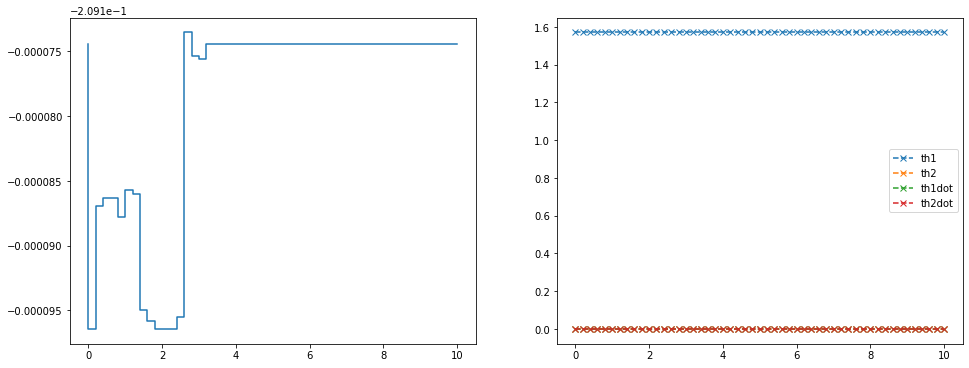

In [9]:
ws_list, model_list, _  = load_trials("seagul/seagul/notebooks/switching/data_needle/longer_thresh")
ws = ws_list[-1]; model = model_list[-1]

#init_state = np.array([0.34992436, 0.3857042 , 0.07708171, 0.59654361])
init_state = np.array([np.pi/2, 0 , 0, 0])
obs_hist, action_hist, reward_hist, lqr_on = do_rollout(np.array(init_state))
   
print("Sum of rewards: ", sum(reward_hist))
print("lqr on?: " , lqr_on)

env = gym.make(ws['env_name'], **ws['env_config'])
t = np.array([i*env.dt*env.act_hold for i in range(len(action_hist))])

fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].step(t, action_hist)
ax[1].plot(t, obs_hist, 'x--')
ax[1].legend(['th1', 'th2', 'th1dot', 'th2dot'])
plt.show()

# Needle sac can be made to work well

## Observation: Bigger networks and longer runs improve performance (shocking...)

## worth noting the one successful rllib trial from last week was a [256, 256] network, and trying to replicate those results with a [32,32] failed

/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'seagul.nn.MLP' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


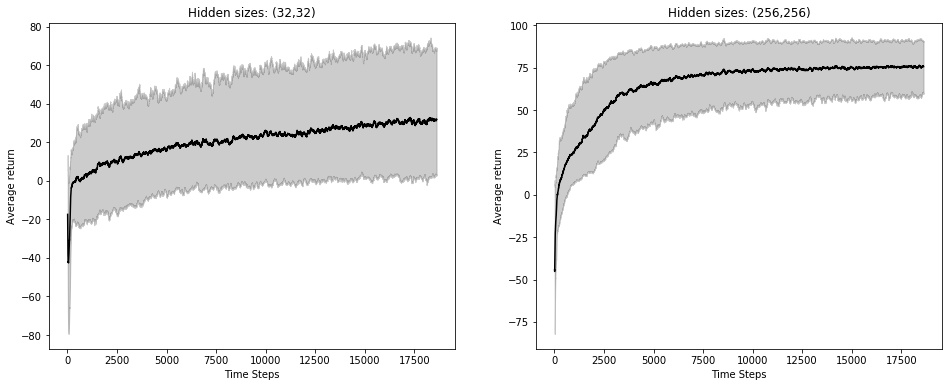

In [13]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ws_list, model_list, rewards = load_trials("seagul/seagul/notebooks/switching/data_needle/long_small_strong")

smooth_bounded_curve(rewards, ax=ax[0])
ax[0].set_title('Hidden sizes: (32,32)')

ws_list, model_list, rewards = load_trials("seagul/seagul/notebooks/switching/data_needle/long_strong_big")
smooth_bounded_curve(rewards,ax = ax[1])
ax[1].set_title('Hidden sizes: (256,256)')

ws = ws_list[-1]; model = model_list[-1]

# Again, reasonably robust to initial conditions

### This time environment is reset normally, but with randomized initial *position* (initial velocity is always zero, learning degrades dramatically with nonzero starting velocities)

In [6]:
# Generate "balance map" at slice dth = 0
pool = Pool()
th1_min = 0; th1_max = 2*pi; num_th1 = 41
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -pi; th2_max = pi; num_th2 = 41
th2_vals = np.linspace(th2_min, th2_max, num_th2)

th_results = np.zeros((th1_vals.size, th2_vals.size))
th_lqr_results = np.zeros((th1_vals.size, th2_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product(th1_vals, th2_vals, [0], [0]))):
    obs_hist, action_hist, reward_hist, lqr_on = res
    errs = np.sum(abs(obs_hist[-10:] - end_point) , axis=1) < 1.5 
    th_results.flat[i] = errs.all()
    th_lqr_results.flat[i] = lqr_on
    rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

32.61735939979553


In [7]:
# Generate "balance map" at slice th = 0

dth1_min = -10; dth1_max = 10; num_dth1 = 41
dth1_vals = np.linspace(dth1_min, dth1_max, num_dth1)

dth2_min = -30; dth2_max = 30; num_dth2 = 41
dth2_vals = np.linspace(dth2_min, dth2_max, num_dth2)

dth_results = np.zeros((dth1_vals.size, dth2_vals.size))
dth_lqr_results = np.zeros((dth1_vals.size, dth2_vals.size))
rewards = np.zeros((dth1_vals.size, dth2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product([0],[0] , dth1_vals, dth2_vals))):
    obs_hist, action_hist, reward_hist, lqr_on = res
    errs = np.sum(abs(obs_hist[-5:] - end_point) , axis=1) < 1.5 
    dth_results.flat[i] = errs.all()
    dth_lqr_results.flat[i] = lqr_on
    rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

28.65541124343872


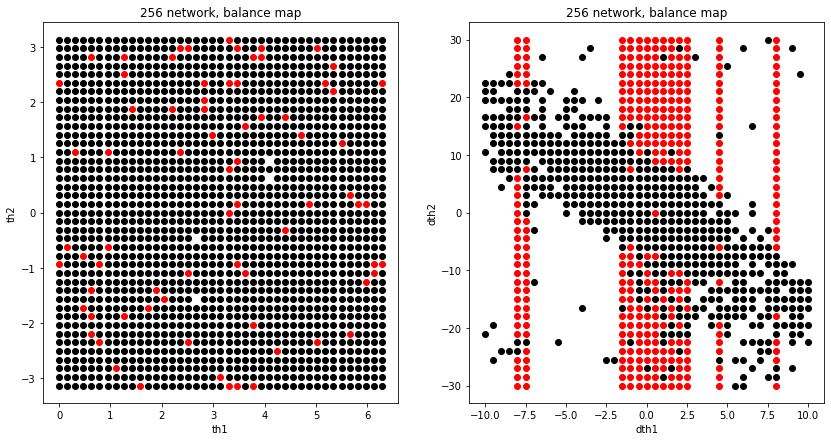

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

weird_list = []
for i in range(th1_vals.shape[0]):
    for j in range(th2_vals.shape[0]):
        if th_lqr_results[i,j] and th_results[i,j]:
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'k', alpha=1)
            
        elif th_lqr_results[i,i] and not th_results[i,j]:            
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'r', alpha=1)
            
        elif th_results[i,j] and not th_lqr_results[i,j]:
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'b', alpha=1)
            weird_list.append((i,j))
            

ax[0].set_title('256 network, balance map')
ax[0].set_xlabel('th1')
ax[0].set_ylabel('th2') 
            
weird_list = []
for i in range(dth1_vals.shape[0]):
    for j in range(dth2_vals.shape[0]):
        if dth_lqr_results[i,j] and dth_results[i,j]:
            ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'k', alpha=1)
            
        elif dth_lqr_results[i,i] and not dth_results[i,j]:            
            ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'r', alpha=1)
            
        elif dth_results[i,j] and not dth_lqr_results[i,j]:
            ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'b', alpha=1)
            weird_list.append((i,j))

            
ax[1].set_title('256 network, balance map')
ax[1].set_xlabel('dth1')
ax[1].set_ylabel('dth2')         
plt.show()

# Manual curriculum learning

## starting with the policy trained above, train again but now with a stricter criteria for the goal state (must be in goal for 25 observations in the past)

In [3]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ws_list, model_list, rewards1 = load_trials("seagul/seagul/notebooks/switching/data_needle/long_strong_big")

smooth_bounded_curve(rewards1, ax=ax[0])
ax[0].set_ylim(-75, 100)
ax[0].set_title('First round of training')

ws_list, model_list, rewards2 = load_trials("seagul/seagul/notebooks/switching/data_needle/better")
smooth_bounded_curve(rewards2,ax = ax[1])
ax[1].set_ylim(-75, 100)
ax[1].set_title('Second round with stricter needle criteria')

ws = ws_list[-1]; model = model_list[-1]

fig, axc = smooth_bounded_curve(np.concatenate((rewards1,rewards2)))
axc.set_title('combined reward curve')
plt.show()

NameError: name 'plt' is not defined

# Despite the reward curve, new policy does seem more robust

In [ ]:
 # Generate "balance map" at slice dth = 0
pool = Pool()
th1_min = 0; th1_max = 2*pi; num_th1 = 41
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -pi; th2_max = pi; num_th2 = 41
th2_vals = np.linspace(th2_min, th2_max, num_th2)

err_list = []

th_results = np.zeros((th1_vals.size, th2_vals.size))
th_lqr_results = np.zeros((th1_vals.size, th2_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product(th1_vals, th2_vals, [0], [0]))):
    obs_hist, action_hist, reward_hist, lqr_on = res
    errs = np.sum(abs(obs_hist[-10:] - end_point) , axis=1)
    err_list.append(errs)
    #th_results.flat[i] = [errs]
    th_lqr_results.flat[i] = lqr_on
    rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

In [34]:
# Generate "balance map" at slice th = 0

dth1_min = -10; dth1_max = 10; num_dth1 = 41
dth1_vals = np.linspace(dth1_min, dth1_max, num_dth1)

dth2_min = -30; dth2_max = 30; num_dth2 = 41
dth2_vals = np.linspace(dth2_min, dth2_max, num_dth2)

dth_results = np.zeros((dth1_vals.size, dth2_vals.size))
dth_lqr_results = np.zeros((dth1_vals.size, dth2_vals.size))
rewards = np.zeros((dth1_vals.size, dth2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product([0],[0] , dth1_vals, dth2_vals))):
    obs_hist, action_hist, reward_hist, lqr_on = res
    errs = np.sum(abs(obs_hist[-10:] - end_point) , axis=1) < 1.5 
    dth_results.flat[i] = errs.all()
    dth_lqr_results.flat[i] = lqr_on
    rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

23.84462261199951


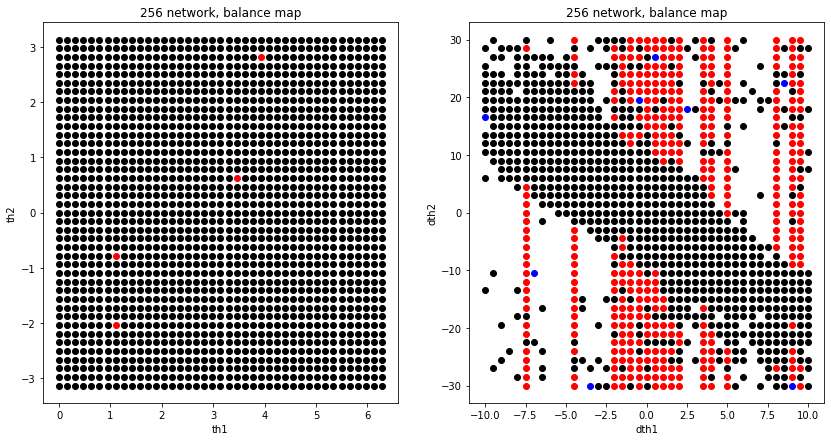

In [35]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

weird_list = []
for i in range(th1_vals.shape[0]):
    for j in range(th2_vals.shape[0]):
        if th_lqr_results[i,j] and th_results[i,j]:
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'k', alpha=1)
            
        elif th_lqr_results[i,i] and not th_results[i,j]:            
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'r', alpha=1)
            
        elif th_results[i,j] and not th_lqr_results[i,j]:
            ax[0].plot(th1_vals[i], th2_vals[j], 'o', color = 'b', alpha=1)
            weird_list.append((i,j))
            

ax[0].set_title('256 network, balance map')
ax[0].set_xlabel('th1')
ax[0].set_ylabel('th2') 
            
weird_list = []
for i in range(dth1_vals.shape[0]):
    for j in range(dth2_vals.shape[0]):
        if dth_lqr_results[i,j] and dth_results[i,j]:
            ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'k', alpha=1)
            
        elif dth_lqr_results[i,i] and not dth_results[i,j]:            
           ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'r', alpha=1)
            
        elif dth_results[i,j] and not dth_lqr_results[i,j]:
           ax[1].plot(dth1_vals[i], dth2_vals[j], 'o', color = 'b', alpha=1)
           weird_list.append((i,j))

            
ax[1].set_title('256 network, balance map')
ax[1].set_xlabel('dth1')
ax[1].set_ylabel('dth2')         
plt.show()

# Need to figure out what to focus on for this week

## Needs
- Finalize the policy to put in the paper
- Do some analysis (what exactly?)
- Rewrite paper to reflect changes (probably rewrite parts of intro too)
- Regenerate plots 
- Clean up / publish code
- Redo comparisons, add d4pg **Problem:** No official implementations available
- Add online gate learning?? (if no, signifigant rewrite of intro / related work need)

## Wants
- Tune hyper params for algo comparisons, if not then use params tuned for Acrobot-v1
- Get cartpole working with the same trick
- Curriculum learning / adaptive alpha
- Learn gate controller
- Can we say/prove anything about this algorithm

## Future Work
- Statistical information about where the system goes with random actions (AKA why is the acrobot problem so hard?)
- Cartpole n+1 n+2
- Replicate and beat results from deep mind paper

# Criticisms 

- To many params specifically tuned to this problem, no suprise it works well
- Euler Integration is lame and/or "cheating" 
- No proofs!
- Too much offline learning (which relies on reseting the environment in arbitrary states) which can't be replicated on a physical system
- Can't compare performance to d4pg, since params tuned for all problems in dm_control